In [1]:
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.backend import BaseEmbedder
from sentence_transformers import SentenceTransformer

from umap import UMAP
from hdbscan import HDBSCAN
from keybert import KeyBERT
import hdbscan


# Step 1: Load data
gold_df = pd.read_csv("gold-dataset-sinha-khandait.csv")
headlines = gold_df["News"].dropna().astype(str).tolist()

/Users/visheshgupta/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
headlines

['april gold down 20 cents to settle at $1,116.10/oz',
 'gold suffers third straight daily decline',
 'Gold futures edge up after two-session decline',
 "dent research : is gold's day in the sun coming soon?",
 'Gold snaps three-day rally as Trump, lawmakers reach debt-ceiling deal',
 'Dec. gold climbs $9.40, or 0.7%, to settle at $1,356.90/oz',
 'gold falls by rs 25 on sluggish demand, global cues',
 'Gold futures fall for the session, but gain for the week',
 'Gold struggles; silver slides, base metals falter',
 'april gold holds slight gain, up $2.50, or 0.2%, at $1320.20/oz.',
 'feb. gold ends up $9.60, or 1.1%, at $901.60 an ounce',
 'gold trades in red in early trade; eyes near-term range at rs 28,300-28,600',
 'gold loses 1.3%, but logs monthly gain of 6.3%',
 "gold recovery? here's one way to play it",
 'gold prices rebound rs 350 on global cues, weak rupee',
 'can investment in gold, sensex & ppfs give the same returns?',
 'gold rush spooks economy as trade deficit surges to $

In [3]:
import re
import numpy as np

headlines_lower = [h.lower() for h in headlines]

months = r"\b(january|february|march|april|may|june|july|august|september|october|november|december|jan|feb|mar|apr|jun|jul|aug|sep|oct|nov|dec)\b"
directions = r"\b(up|down|higher|lower|rise|rises|fall|falls|gain|gains|loses|loss|rebound|slip|climb|surge|drop|drops|edged|edges|recover|recovery|recovers|flat)\b"
numbers = r"[\d\.,]+[%$]?|\d{1,3}(,\d{3})*(\.\d+)?|\d+"
symbols = r"\/oz|rs|bn|usd|\$|%|oz"

cleaned_headlines = []
for h in headlines_lower:
    h_clean = re.sub(months, "", h, flags=re.IGNORECASE)
    h_clean = re.sub(directions, "", h_clean, flags=re.IGNORECASE)
    h_clean = re.sub(numbers, "", h_clean)
    h_clean = re.sub(symbols, "", h_clean, flags=re.IGNORECASE)
    h_clean = re.sub(r"[^\w\s]", "", h_clean)  # remove punctuation
    h_clean = re.sub(r"\s+", " ", h_clean).strip()  # clean up spaces
    cleaned_headlines.append(h_clean.lower())

In [4]:
embedding_model = SentenceTransformer("all-mpnet-base-v2")

In [5]:
vectorizer = CountVectorizer(
    stop_words="english",
    ngram_range=(1, 3),  # uptil trigrams
    min_df=10,  # ignore words in less than 10 headlines (0.1%)
    max_df=0.5,  # ignore words in more than 50% headlines
    max_features=5_000,
    token_pattern=r"(?u)\b[\w\-]+\b",  # Keep hyphenated phrases (e.g., "AI-driven")
)

In [6]:
hdbscan_model = HDBSCAN(
    min_cluster_size=60,  # Test values between 30-100
    min_samples=10,  # Avoids micro-clusters (10-30% of min_cluster_size)
    cluster_selection_epsilon=0.1,  # Merges nearby clusters
    prediction_data=True,  # for soft clustering
)

topic_model = BERTopic(
    embedding_model="all-mpnet-base-v2",
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer,
    verbose=True,
)

In [7]:
topics, probs = topic_model.fit_transform(cleaned_headlines)

2025-04-12 14:01:02,472 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 331/331 [00:15<00:00, 21.10it/s]
2025-04-12 14:01:19,179 - BERTopic - Embedding - Completed ✓
2025-04-12 14:01:19,179 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-04-12 14:01:27,542 - BERTopic - Dimensionality - Completed ✓
2025-04-12 14:01:27,543 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-12 14:01:27,729 - BERTopic - Cluster - Completed ✓
2025-04-12 14:01:27,734 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-12 14:01:27,843 - BERTopic - Representation - Completed ✓


In [8]:
topic_model.hdbscan_model.probabilities_

array([0., 1., 1., ..., 1., 1., 1.])

In [9]:
(probs == topic_model.hdbscan_model.probabilities_).all()

True

In [10]:
prob_matrix = np.array(hdbscan.all_points_membership_vectors(topic_model.hdbscan_model))

In [11]:
prob_matrix

array([[5.28943372e-003, 3.24716214e-003, 3.73994620e-003, ...,
        8.13547641e-003, 7.48872089e-003, 6.74021701e-003],
       [8.74894349e-309, 7.16361771e-309, 1.27081225e-308, ...,
        3.55479740e-308, 4.03942505e-308, 3.41167338e-308],
       [8.19985546e-309, 6.99531847e-309, 1.00313524e-308, ...,
        5.48984789e-308, 7.10897883e-308, 4.92595484e-308],
       ...,
       [3.28588008e-003, 2.96154177e-003, 4.45122458e-003, ...,
        2.54035735e-002, 3.71711477e-002, 2.94062858e-002],
       [6.53681807e-309, 8.40499063e-309, 1.19914589e-308, ...,
        1.36350893e-308, 1.40972541e-308, 1.46112071e-308],
       [6.53682772e-309, 8.40495232e-309, 1.19914370e-308, ...,
        1.36350127e-308, 1.40971575e-308, 1.46111114e-308]])

In [12]:
normalized_prob = prob_matrix / prob_matrix.sum(axis=1, keepdims=True)

In [13]:
normalized_prob[1]

array([8.74894349e-309, 7.16361771e-309, 1.27081225e-308, 9.39898618e-309,
       8.24691159e-309, 1.17083040e-308, 1.40327899e-308, 1.05454231e-308,
       1.20467061e-308, 1.11260926e-308, 9.98559416e-309, 1.81856910e-308,
       2.06940051e-308, 2.29314036e-308, 5.12570819e-308, 2.15414073e-308,
       2.74409446e-308, 1.00000000e+000, 4.32273666e-308, 3.13724834e-308,
       5.84188539e-308, 4.15510904e-308, 4.31638406e-308, 2.83921527e-308,
       2.34195369e-308, 2.64611489e-308, 4.37030858e-308, 3.80530255e-308,
       4.31358401e-308, 6.20258774e-308, 4.88265363e-308, 3.42780242e-308,
       2.64426126e-308, 3.55479740e-308, 4.03942505e-308, 3.41167338e-308])

In [14]:
def get_hdbscan_probabilities(topic_model, documents):
    """Get full probability distributions for HDBSCAN using soft clustering"""
    # First ensure we have prediction data
    if not hasattr(topic_model.hdbscan_model, "prediction_data_"):
        raise ValueError("HDBSCAN needs to be initialized with prediction_data=True")

    # Get embeddings
    embeddings = topic_model._extract_embeddings(documents)

    # Get all cluster probabilities using HDBSCAN's soft clustering
    soft_clusters = hdbscan.all_points_membership_vectors(topic_model.hdbscan_model)

    # Convert to numpy array and normalize
    prob_matrix = np.array(soft_clusters)
    normalized_probs = prob_matrix / prob_matrix.sum(axis=1, keepdims=True)

    return normalized_probs
    # return prob_matrix


# Usage:
hdbscan_probs = get_hdbscan_probabilities(topic_model, cleaned_headlines)

In [15]:
hdbscan_probs

array([[2.28384877e-002, 1.40204559e-002, 1.61481776e-002, ...,
        3.51270075e-002, 3.23344745e-002, 2.91026169e-002],
       [8.74894349e-309, 7.16361771e-309, 1.27081225e-308, ...,
        3.55479740e-308, 4.03942505e-308, 3.41167338e-308],
       [8.19985546e-309, 6.99531847e-309, 1.00313524e-308, ...,
        5.48984789e-308, 7.10897883e-308, 4.92595484e-308],
       ...,
       [3.28588008e-003, 2.96154177e-003, 4.45122458e-003, ...,
        2.54035735e-002, 3.71711477e-002, 2.94062858e-002],
       [6.53681807e-309, 8.40499063e-309, 1.19914589e-308, ...,
        1.36350893e-308, 1.40972541e-308, 1.46112071e-308],
       [6.53682772e-309, 8.40495232e-309, 1.19914370e-308, ...,
        1.36350127e-308, 1.40971575e-308, 1.46111114e-308]])

In [16]:
hdbscan_probs[1] == max(hdbscan_probs[1])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [17]:
n_topics = hdbscan_probs.shape[1]
column_names = [str(i) for i in range(0, n_topics)]

prob_df = pd.DataFrame(hdbscan_probs, columns=column_names)

In [18]:
prob_df

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,2.283849e-02,1.402046e-02,1.614818e-02,1.875945e-02,1.760760e-02,1.867192e-02,1.721324e-02,1.512755e-02,1.744773e-02,1.667150e-02,...,3.295844e-02,3.572198e-02,3.247931e-02,3.346979e-02,3.786850e-02,3.041266e-02,2.770584e-02,3.512701e-02,3.233447e-02,2.910262e-02
1,8.748943e-309,7.163618e-309,1.270812e-308,9.398986e-309,8.246912e-309,1.170830e-308,1.403279e-308,1.054542e-308,1.204671e-308,1.112609e-308,...,4.370309e-308,3.805303e-308,4.313584e-308,6.202588e-308,4.882654e-308,3.427802e-308,2.644261e-308,3.554797e-308,4.039425e-308,3.411673e-308
2,8.199855e-309,6.995318e-309,1.003135e-308,1.160200e-308,9.050506e-309,1.060557e-308,1.301338e-308,9.722602e-309,1.050516e-308,9.562994e-309,...,3.104085e-307,6.795310e-308,1.000000e+00,1.784047e-307,6.934975e-308,4.211338e-308,3.335190e-308,5.489848e-308,7.108979e-308,4.925955e-308
3,7.645843e-309,8.658651e-309,1.007924e-308,9.931215e-309,9.179729e-309,8.943314e-309,1.658564e-308,1.207071e-308,1.303081e-308,1.146434e-308,...,4.483959e-308,5.627556e-308,3.647994e-308,3.448045e-308,5.105556e-308,7.453425e-308,5.152811e-308,4.543721e-308,7.056816e-308,4.600916e-308
4,3.422318e-03,3.313719e-03,4.413704e-03,4.308059e-03,4.599872e-03,4.414482e-03,7.126344e-03,4.988977e-03,4.762620e-03,4.298298e-03,...,3.593568e-02,3.983067e-02,2.609327e-02,2.253066e-02,3.448307e-02,7.237842e-02,3.867242e-02,5.022091e-02,8.339184e-02,2.393919e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10565,2.542451e-03,2.202854e-03,3.455016e-03,2.854749e-03,2.731068e-03,3.316220e-03,4.449942e-03,3.208422e-03,3.422148e-03,3.131927e-03,...,1.873011e-02,1.627491e-02,1.595591e-02,1.896204e-02,2.093056e-02,1.568752e-02,1.085144e-02,1.616860e-02,2.019150e-02,1.561444e-02
10566,7.490500e-309,8.670655e-309,9.515465e-309,1.023595e-308,9.473785e-309,8.734067e-309,1.629178e-308,1.226073e-308,1.282935e-308,1.121194e-308,...,4.332395e-308,5.824902e-308,3.491312e-308,3.143857e-308,4.677446e-308,7.226353e-308,5.346830e-308,4.613434e-308,6.917584e-308,4.632731e-308
10567,3.285880e-03,2.961542e-03,4.451225e-03,3.801242e-03,3.828361e-03,4.303121e-03,6.239479e-03,4.374559e-03,4.461618e-03,4.068127e-03,...,2.752648e-02,2.349916e-02,2.135389e-02,2.222515e-02,2.576929e-02,2.726694e-02,1.766332e-02,2.540357e-02,3.717115e-02,2.940629e-02
10568,6.536818e-309,8.404991e-309,1.199146e-308,6.640056e-309,8.736814e-309,9.426290e-309,1.981696e-308,1.000000e+00,1.734534e-308,1.672686e-308,...,1.299375e-308,1.335172e-308,1.248824e-308,1.273933e-308,1.346062e-308,1.467211e-308,1.439511e-308,1.363509e-308,1.409725e-308,1.461121e-308


In [19]:
topic_columns = [col for col in prob_df.columns]

prob_df["dominant_topic"] = prob_df[topic_columns].idxmax(axis=1)

In [20]:
prob_df["topic"] = topics

In [21]:
# BERTopic's topic mapping
topic_mapping = topic_model.topic_mapper_.get_mappings()
print(topic_mapping)

{-1: -1, 0: 19, 1: 11, 2: 28, 3: 21, 4: 23, 5: 16, 6: 10, 7: 34, 8: 30, 9: 25, 10: 32, 11: 17, 12: 7, 13: 29, 14: 24, 15: 14, 16: 33, 17: 0, 18: 31, 19: 26, 20: 18, 21: 13, 22: 1, 23: 27, 24: 2, 25: 9, 26: 35, 27: 20, 28: 22, 29: 4, 30: 15, 31: 12, 32: 6, 33: 5, 34: 8, 35: 3}


In [22]:
prob_df

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,dominant_topic,topic
0,2.283849e-02,1.402046e-02,1.614818e-02,1.875945e-02,1.760760e-02,1.867192e-02,1.721324e-02,1.512755e-02,1.744773e-02,1.667150e-02,...,3.247931e-02,3.346979e-02,3.786850e-02,3.041266e-02,2.770584e-02,3.512701e-02,3.233447e-02,2.910262e-02,20,-1
1,8.748943e-309,7.163618e-309,1.270812e-308,9.398986e-309,8.246912e-309,1.170830e-308,1.403279e-308,1.054542e-308,1.204671e-308,1.112609e-308,...,4.313584e-308,6.202588e-308,4.882654e-308,3.427802e-308,2.644261e-308,3.554797e-308,4.039425e-308,3.411673e-308,17,0
2,8.199855e-309,6.995318e-309,1.003135e-308,1.160200e-308,9.050506e-309,1.060557e-308,1.301338e-308,9.722602e-309,1.050516e-308,9.562994e-309,...,1.000000e+00,1.784047e-307,6.934975e-308,4.211338e-308,3.335190e-308,5.489848e-308,7.108979e-308,4.925955e-308,28,22
3,7.645843e-309,8.658651e-309,1.007924e-308,9.931215e-309,9.179729e-309,8.943314e-309,1.658564e-308,1.207071e-308,1.303081e-308,1.146434e-308,...,3.647994e-308,3.448045e-308,5.105556e-308,7.453425e-308,5.152811e-308,4.543721e-308,7.056816e-308,4.600916e-308,22,1
4,3.422318e-03,3.313719e-03,4.413704e-03,4.308059e-03,4.599872e-03,4.414482e-03,7.126344e-03,4.988977e-03,4.762620e-03,4.298298e-03,...,2.609327e-02,2.253066e-02,3.448307e-02,7.237842e-02,3.867242e-02,5.022091e-02,8.339184e-02,2.393919e-01,35,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10565,2.542451e-03,2.202854e-03,3.455016e-03,2.854749e-03,2.731068e-03,3.316220e-03,4.449942e-03,3.208422e-03,3.422148e-03,3.131927e-03,...,1.595591e-02,1.896204e-02,2.093056e-02,1.568752e-02,1.085144e-02,1.616860e-02,2.019150e-02,1.561444e-02,17,0
10566,7.490500e-309,8.670655e-309,9.515465e-309,1.023595e-308,9.473785e-309,8.734067e-309,1.629178e-308,1.226073e-308,1.282935e-308,1.121194e-308,...,3.491312e-308,3.143857e-308,4.677446e-308,7.226353e-308,5.346830e-308,4.613434e-308,6.917584e-308,4.632731e-308,22,1
10567,3.285880e-03,2.961542e-03,4.451225e-03,3.801242e-03,3.828361e-03,4.303121e-03,6.239479e-03,4.374559e-03,4.461618e-03,4.068127e-03,...,2.135389e-02,2.222515e-02,2.576929e-02,2.726694e-02,1.766332e-02,2.540357e-02,3.717115e-02,2.940629e-02,17,0
10568,6.536818e-309,8.404991e-309,1.199146e-308,6.640056e-309,8.736814e-309,9.426290e-309,1.981696e-308,1.000000e+00,1.734534e-308,1.672686e-308,...,1.248824e-308,1.273933e-308,1.346062e-308,1.467211e-308,1.439511e-308,1.363509e-308,1.409725e-308,1.461121e-308,7,34


In [23]:
prob_df["topic"] = (
    pd.to_numeric(prob_df["topic"], errors="coerce").fillna(-1).astype(int)
)
prob_df["dominant_topic"] = (
    pd.to_numeric(prob_df["dominant_topic"], errors="coerce").fillna(-1).astype(int)
)
prob_df["mapped_topic"] = prob_df["dominant_topic"].map(topic_mapping)
prob_df

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,dominant_topic,topic,mapped_topic
0,2.283849e-02,1.402046e-02,1.614818e-02,1.875945e-02,1.760760e-02,1.867192e-02,1.721324e-02,1.512755e-02,1.744773e-02,1.667150e-02,...,3.346979e-02,3.786850e-02,3.041266e-02,2.770584e-02,3.512701e-02,3.233447e-02,2.910262e-02,20,-1,18
1,8.748943e-309,7.163618e-309,1.270812e-308,9.398986e-309,8.246912e-309,1.170830e-308,1.403279e-308,1.054542e-308,1.204671e-308,1.112609e-308,...,6.202588e-308,4.882654e-308,3.427802e-308,2.644261e-308,3.554797e-308,4.039425e-308,3.411673e-308,17,0,0
2,8.199855e-309,6.995318e-309,1.003135e-308,1.160200e-308,9.050506e-309,1.060557e-308,1.301338e-308,9.722602e-309,1.050516e-308,9.562994e-309,...,1.784047e-307,6.934975e-308,4.211338e-308,3.335190e-308,5.489848e-308,7.108979e-308,4.925955e-308,28,22,22
3,7.645843e-309,8.658651e-309,1.007924e-308,9.931215e-309,9.179729e-309,8.943314e-309,1.658564e-308,1.207071e-308,1.303081e-308,1.146434e-308,...,3.448045e-308,5.105556e-308,7.453425e-308,5.152811e-308,4.543721e-308,7.056816e-308,4.600916e-308,22,1,1
4,3.422318e-03,3.313719e-03,4.413704e-03,4.308059e-03,4.599872e-03,4.414482e-03,7.126344e-03,4.988977e-03,4.762620e-03,4.298298e-03,...,2.253066e-02,3.448307e-02,7.237842e-02,3.867242e-02,5.022091e-02,8.339184e-02,2.393919e-01,35,-1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10565,2.542451e-03,2.202854e-03,3.455016e-03,2.854749e-03,2.731068e-03,3.316220e-03,4.449942e-03,3.208422e-03,3.422148e-03,3.131927e-03,...,1.896204e-02,2.093056e-02,1.568752e-02,1.085144e-02,1.616860e-02,2.019150e-02,1.561444e-02,17,0,0
10566,7.490500e-309,8.670655e-309,9.515465e-309,1.023595e-308,9.473785e-309,8.734067e-309,1.629178e-308,1.226073e-308,1.282935e-308,1.121194e-308,...,3.143857e-308,4.677446e-308,7.226353e-308,5.346830e-308,4.613434e-308,6.917584e-308,4.632731e-308,22,1,1
10567,3.285880e-03,2.961542e-03,4.451225e-03,3.801242e-03,3.828361e-03,4.303121e-03,6.239479e-03,4.374559e-03,4.461618e-03,4.068127e-03,...,2.222515e-02,2.576929e-02,2.726694e-02,1.766332e-02,2.540357e-02,3.717115e-02,2.940629e-02,17,0,0
10568,6.536818e-309,8.404991e-309,1.199146e-308,6.640056e-309,8.736814e-309,9.426290e-309,1.981696e-308,1.000000e+00,1.734534e-308,1.672686e-308,...,1.273933e-308,1.346062e-308,1.467211e-308,1.439511e-308,1.363509e-308,1.409725e-308,1.461121e-308,7,34,34


In [24]:
prob_df[prob_df["topic"] == -1]

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,dominant_topic,topic,mapped_topic
0,0.022838,0.014020,0.016148,0.018759,0.017608,0.018672,0.017213,0.015128,0.017448,0.016672,...,0.033470,0.037869,0.030413,0.027706,0.035127,0.032334,0.029103,20,-1,18
4,0.003422,0.003314,0.004414,0.004308,0.004600,0.004414,0.007126,0.004989,0.004763,0.004298,...,0.022531,0.034483,0.072378,0.038672,0.050221,0.083392,0.239392,35,-1,3
5,0.024796,0.013123,0.014485,0.019012,0.027332,0.021058,0.018124,0.016988,0.016886,0.016043,...,0.032181,0.038165,0.032000,0.029797,0.039832,0.033492,0.032856,33,-1,5
17,0.005330,0.004467,0.006211,0.008714,0.005811,0.006789,0.007804,0.005957,0.006527,0.005963,...,0.072064,0.037685,0.026627,0.023088,0.033007,0.037452,0.029865,28,-1,22
20,0.008339,0.015311,0.010395,0.012166,0.010808,0.008889,0.018943,0.017628,0.020252,0.016953,...,0.022871,0.027230,0.031325,0.030862,0.026678,0.029930,0.026501,13,-1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10519,0.012617,0.014497,0.031774,0.012749,0.012918,0.018672,0.032033,0.050113,0.051199,0.054597,...,0.027424,0.027138,0.027645,0.026062,0.025643,0.027189,0.026877,9,-1,25
10530,0.003652,0.003454,0.004779,0.004448,0.004296,0.004585,0.006985,0.004988,0.005191,0.004685,...,0.033515,0.052736,0.054455,0.030769,0.045086,0.081081,0.047416,17,-1,0
10544,0.008357,0.009268,0.011636,0.009516,0.008086,0.009443,0.015287,0.012893,0.017559,0.015386,...,0.026568,0.032234,0.029489,0.025033,0.026287,0.030109,0.025216,20,-1,18
10556,0.005682,0.006328,0.007689,0.009210,0.006754,0.007154,0.012706,0.010059,0.011012,0.009486,...,0.033324,0.032863,0.034922,0.031308,0.030655,0.039983,0.032594,25,-1,9


In [25]:
prob_df["matching"] = prob_df["topic"] == prob_df["mapped_topic"]
prob_df["matching"].sum()

8303

In [26]:
7621 / prob_df.shape[0]

0.7210028382213812

In [27]:
2818 + 7621 == prob_df.shape[0]

False

In [ ]:
(2818 + 7621) / 10570

0.9876064333017975

In [29]:
prob_df[prob_df["matching"] == False]["topic"].value_counts()

topic
-1     1998
 7       75
 1       52
 3       48
 6       30
 14      25
 2       15
 5       15
 13       7
 15       1
 22       1
Name: count, dtype: int64

In [30]:
prob_df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,dominant_topic,topic,mapped_topic,matching
0,2.283849e-02,1.402046e-02,1.614818e-02,1.875945e-02,1.760760e-02,1.867192e-02,1.721324e-02,1.512755e-02,1.744773e-02,1.667150e-02,...,3.786850e-02,3.041266e-02,2.770584e-02,3.512701e-02,3.233447e-02,2.910262e-02,20,-1,18,False
1,8.748943e-309,7.163618e-309,1.270812e-308,9.398986e-309,8.246912e-309,1.170830e-308,1.403279e-308,1.054542e-308,1.204671e-308,1.112609e-308,...,4.882654e-308,3.427802e-308,2.644261e-308,3.554797e-308,4.039425e-308,3.411673e-308,17,0,0,True
2,8.199855e-309,6.995318e-309,1.003135e-308,1.160200e-308,9.050506e-309,1.060557e-308,1.301338e-308,9.722602e-309,1.050516e-308,9.562994e-309,...,6.934975e-308,4.211338e-308,3.335190e-308,5.489848e-308,7.108979e-308,4.925955e-308,28,22,22,True
3,7.645843e-309,8.658651e-309,1.007924e-308,9.931215e-309,9.179729e-309,8.943314e-309,1.658564e-308,1.207071e-308,1.303081e-308,1.146434e-308,...,5.105556e-308,7.453425e-308,5.152811e-308,4.543721e-308,7.056816e-308,4.600916e-308,22,1,1,True
4,3.422318e-03,3.313719e-03,4.413704e-03,4.308059e-03,4.599872e-03,4.414482e-03,7.126344e-03,4.988977e-03,4.762620e-03,4.298298e-03,...,3.448307e-02,7.237842e-02,3.867242e-02,5.022091e-02,8.339184e-02,2.393919e-01,35,-1,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10565,2.542451e-03,2.202854e-03,3.455016e-03,2.854749e-03,2.731068e-03,3.316220e-03,4.449942e-03,3.208422e-03,3.422148e-03,3.131927e-03,...,2.093056e-02,1.568752e-02,1.085144e-02,1.616860e-02,2.019150e-02,1.561444e-02,17,0,0,True
10566,7.490500e-309,8.670655e-309,9.515465e-309,1.023595e-308,9.473785e-309,8.734067e-309,1.629178e-308,1.226073e-308,1.282935e-308,1.121194e-308,...,4.677446e-308,7.226353e-308,5.346830e-308,4.613434e-308,6.917584e-308,4.632731e-308,22,1,1,True
10567,3.285880e-03,2.961542e-03,4.451225e-03,3.801242e-03,3.828361e-03,4.303121e-03,6.239479e-03,4.374559e-03,4.461618e-03,4.068127e-03,...,2.576929e-02,2.726694e-02,1.766332e-02,2.540357e-02,3.717115e-02,2.940629e-02,17,0,0,True
10568,6.536818e-309,8.404991e-309,1.199146e-308,6.640056e-309,8.736814e-309,9.426290e-309,1.981696e-308,1.000000e+00,1.734534e-308,1.672686e-308,...,1.346062e-308,1.467211e-308,1.439511e-308,1.363509e-308,1.409725e-308,1.461121e-308,7,34,34,True


In [31]:
topic_model.topic_embeddings_

array([[-0.01426669,  0.00650841, -0.00652124, ...,  0.00878666,
        -0.01212744, -0.00268435],
       [-0.03763002,  0.0139226 , -0.00093042, ...,  0.00011606,
        -0.00789844,  0.0040985 ],
       [ 0.00096503,  0.01652302, -0.0122045 , ...,  0.02438289,
        -0.00020958, -0.00586181],
       ...,
       [-0.02416724,  0.0092756 , -0.00371614, ...,  0.02301508,
        -0.00786887, -0.02874393],
       [-0.01662857,  0.00610313, -0.00064475, ..., -0.02064614,
         0.01160482,  0.00202908],
       [-0.05147851,  0.05172383, -0.00743512, ...,  0.00636242,
        -0.03571234, -0.01637728]], dtype=float32)

In [34]:
# Get topic embeddings (dimensions: n_topics x embedding_size)
topic_embeddings = topic_model.topic_embeddings_
topic_embeddings.shape

(37, 768)

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity matrix (n_topics x n_topics)
similarity_matrix = cosine_similarity(topic_embeddings)
similarity_matrix

array([[0.9999999 , 0.90195173, 0.9488548 , ..., 0.79686886, 0.8413144 ,
        0.81586134],
       [0.90195173, 0.99999994, 0.8504966 , ..., 0.72553086, 0.70320505,
        0.7474061 ],
       [0.9488548 , 0.8504966 , 1.0000004 , ..., 0.7720057 , 0.7466838 ,
        0.7435712 ],
       ...,
       [0.79686886, 0.72553086, 0.7720057 , ..., 1.0000001 , 0.6103736 ,
        0.78904176],
       [0.8413144 , 0.70320505, 0.7466838 , ..., 0.6103736 , 1.        ,
        0.6540237 ],
       [0.81586134, 0.7474061 , 0.7435712 , ..., 0.78904176, 0.6540237 ,
        1.        ]], dtype=float32)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

n_target_clusters = 10
distance_matrix = 1 - similarity_matrix  # Convert to distance
agg_cluster = AgglomerativeClustering(
    n_clusters=n_target_clusters,
    metric="precomputed",  # Critical fix
    linkage="average",
)
topic_groups = agg_cluster.fit_predict(distance_matrix)

In [ ]:
topic_group_map = pd.DataFrame(
    {"Original_Topic": range(len(topic_groups)), "New_Group": topic_groups}
)

In [41]:
topic_group_map

,Original_Topic,New_Group
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,4
6,6,0
7,7,0
8,8,0
9,9,0


In [39]:
topic_groups

array([0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 1, 0, 0, 4, 8, 4, 9, 1, 1, 0,
       4, 4, 5, 0, 3, 0, 6, 7, 2, 3, 4, 9, 4, 0, 4])

In [42]:
prob_df["merged_group"] = prob_df["mapped_topic"].map(
    topic_group_map.set_index("Original_Topic")["New_Group"]
)

In [43]:
prob_df

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,dominant_topic,topic,mapped_topic,matching,merged_group
0,2.283849e-02,1.402046e-02,1.614818e-02,1.875945e-02,1.760760e-02,1.867192e-02,1.721324e-02,1.512755e-02,1.744773e-02,1.667150e-02,...,3.041266e-02,2.770584e-02,3.512701e-02,3.233447e-02,2.910262e-02,20,-1,18,False,9
1,8.748943e-309,7.163618e-309,1.270812e-308,9.398986e-309,8.246912e-309,1.170830e-308,1.403279e-308,1.054542e-308,1.204671e-308,1.112609e-308,...,3.427802e-308,2.644261e-308,3.554797e-308,4.039425e-308,3.411673e-308,17,0,0,True,0
2,8.199855e-309,6.995318e-309,1.003135e-308,1.160200e-308,9.050506e-309,1.060557e-308,1.301338e-308,9.722602e-309,1.050516e-308,9.562994e-309,...,4.211338e-308,3.335190e-308,5.489848e-308,7.108979e-308,4.925955e-308,28,22,22,True,4
3,7.645843e-309,8.658651e-309,1.007924e-308,9.931215e-309,9.179729e-309,8.943314e-309,1.658564e-308,1.207071e-308,1.303081e-308,1.146434e-308,...,7.453425e-308,5.152811e-308,4.543721e-308,7.056816e-308,4.600916e-308,22,1,1,True,0
4,3.422318e-03,3.313719e-03,4.413704e-03,4.308059e-03,4.599872e-03,4.414482e-03,7.126344e-03,4.988977e-03,4.762620e-03,4.298298e-03,...,7.237842e-02,3.867242e-02,5.022091e-02,8.339184e-02,2.393919e-01,35,-1,3,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10565,2.542451e-03,2.202854e-03,3.455016e-03,2.854749e-03,2.731068e-03,3.316220e-03,4.449942e-03,3.208422e-03,3.422148e-03,3.131927e-03,...,1.568752e-02,1.085144e-02,1.616860e-02,2.019150e-02,1.561444e-02,17,0,0,True,0
10566,7.490500e-309,8.670655e-309,9.515465e-309,1.023595e-308,9.473785e-309,8.734067e-309,1.629178e-308,1.226073e-308,1.282935e-308,1.121194e-308,...,7.226353e-308,5.346830e-308,4.613434e-308,6.917584e-308,4.632731e-308,22,1,1,True,0
10567,3.285880e-03,2.961542e-03,4.451225e-03,3.801242e-03,3.828361e-03,4.303121e-03,6.239479e-03,4.374559e-03,4.461618e-03,4.068127e-03,...,2.726694e-02,1.766332e-02,2.540357e-02,3.717115e-02,2.940629e-02,17,0,0,True,0
10568,6.536818e-309,8.404991e-309,1.199146e-308,6.640056e-309,8.736814e-309,9.426290e-309,1.981696e-308,1.000000e+00,1.734534e-308,1.672686e-308,...,1.467211e-308,1.439511e-308,1.363509e-308,1.409725e-308,1.461121e-308,7,34,34,True,4


In [44]:
# Step 3: Save topics back to dataframe
gold_df_filtered = gold_df.loc[gold_df["News"].notna()].copy()

In [45]:
gold_df_filtered = pd.concat([gold_df_filtered, prob_df], axis=1)

In [46]:
# Step 4: View top 10 topics
print(topic_model.get_topic_info().head(10))

   Topic  Count                                  Name  \
0     -1   1998    -1_cents_closes_gold climbs_climbs   
1      0   1677                 0_high_month_week_low   
2      1   1555           1_global_demand_cues_buying   
3      2    545           2_demand_price_market_sales   
4      3    506                 3_fed_rate_hike_rates   
5      4    409  4_end_week gold_session_session gold   
6      5    384    5_data gold_data_report_gold holds   
7      6    360                6_china_ease_focus_dip   
8      7    200   7_gold trades_today_rate_gold price   
9      8    193     8_dollar gold_remain_steady_eases   

                                      Representation  \
0  [cents, closes, gold climbs, climbs, day, gold...   
1  [high, month, week, low, high gold, near, low ...   
2  [global, demand, cues, buying, buy, demand gol...   
3  [demand, price, market, sales, likely, rates, ...   
4  [fed, rate, hike, rates, steady, gold ends, en...   
5  [end, week gold, session, session

In [48]:
sample_topic = 0  # change this to see different clusters
print(f"\n--- Sample Headlines from Topic {sample_topic} ---")
print(gold_df_filtered[gold_df_filtered["topic"] == sample_topic]["News"].head(5))

# Step 6: Visualize
topic_model.visualize_topics().show()


--- Sample Headlines from Topic 0 ---
1             gold suffers third straight daily decline
12       gold loses 1.3%, but logs monthly gain of 6.3%
22      Gold prices finish at a more than one-week high
32         gold futures at highest since early december
34    Gold edges up ahead of G20 meeting; set to pos...
Name: News, dtype: object


In [49]:
topic_model.visualize_barchart(top_n_topics=10).show()

In [56]:
topic_model.visualize_hierarchy().show()

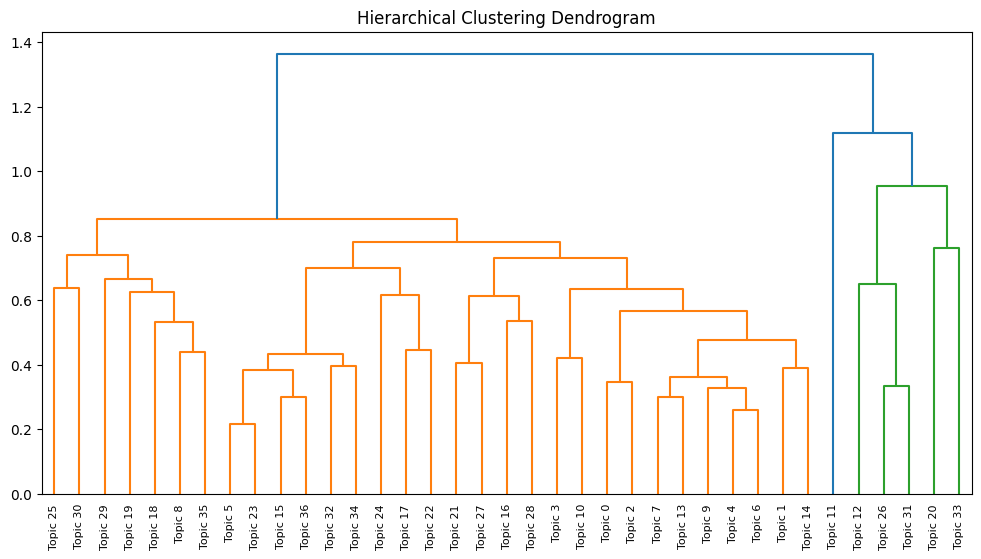

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

Z = linkage(distance_matrix, "average")
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=[f"Topic {i}" for i in range(len(topic_embeddings))])
plt.xticks(rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

In [51]:
topic_model.visualize_heatmap()

In [57]:
gold_df_filtered

,Dates,URL,News,Price Direction Up,Price Direction Constant,Price Direction Down,Asset Comparision,Past Information,Future Information,Price Sentiment,...,31,32,33,34,35,dominant_topic,topic,mapped_topic,matching,merged_group
0,28-01-2016,http://www.marketwatch.com/story/april-gold-do...,"april gold down 20 cents to settle at $1,116.1...",0,0,1,0,1,0,negative,...,3.041266e-02,2.770584e-02,3.512701e-02,3.233447e-02,2.910262e-02,20,-1,18,False,9
1,13-09-2017,http://www.marketwatch.com/story/gold-prices-s...,gold suffers third straight daily decline,0,0,1,0,1,0,negative,...,3.427802e-308,2.644261e-308,3.554797e-308,4.039425e-308,3.411673e-308,17,0,0,True,0
2,26-07-2016,http://www.marketwatch.com/story/gold-futures-...,Gold futures edge up after two-session decline,1,0,0,0,1,0,positive,...,4.211338e-308,3.335190e-308,5.489848e-308,7.108979e-308,4.925955e-308,28,22,22,True,4
3,28-02-2018,https://www.metalsdaily.com/link/277199/dent-r...,dent research : is gold's day in the sun comin...,0,0,0,0,0,1,none,...,7.453425e-308,5.152811e-308,4.543721e-308,7.056816e-308,4.600916e-308,22,1,1,True,0
4,06-09-2017,http://www.marketwatch.com/story/gold-steadies...,"Gold snaps three-day rally as Trump, lawmakers...",0,0,1,0,1,0,negative,...,7.237842e-02,3.867242e-02,5.022091e-02,8.339184e-02,2.393919e-01,35,-1,3,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10565,07-01-2013,https://www.moneycontrol.com/news/business/mar...,gold seen falling from 3-week high this week,0,0,1,0,1,0,negative,...,1.568752e-02,1.085144e-02,1.616860e-02,2.019150e-02,1.561444e-02,17,0,0,True,0
10566,27-09-2018,https://www.metalsdaily.com/link/284468/domini...,dominic frisby : now looks like a good time to...,1,0,0,0,0,1,positive,...,7.226353e-308,5.346830e-308,4.613434e-308,6.917584e-308,4.632731e-308,22,1,1,True,0
10567,03-03-2017,https://www.thehindubusinessline.com/markets/g...,Gold heading for worst week since November on ...,0,0,1,0,1,0,negative,...,2.726694e-02,1.766332e-02,2.540357e-02,3.717115e-02,2.940629e-02,17,0,0,True,0
10568,11-06-2008,http://www.marketwatch.com/story/august-gold-u...,august gold up $7.60 at $878.80 an ounce on nymex,1,0,0,0,1,0,positive,...,1.467211e-308,1.439511e-308,1.363509e-308,1.409725e-308,1.461121e-308,7,34,34,True,4


In [ ]:
gold_df_filtered["merged_group"].value_counts()

merged_group
0    7290
4    1237
1     520
9     430
3     263
2     250
7     218
5     138
8     121
6     103
Name: count, dtype: int64

In [ ]:
gold_df_filtered[gold_df_filtered["merged_group"] == 9]["News"][:30]

0      april gold down 20 cents to settle at $1,116.1...
9      april gold holds slight gain, up $2.50, or 0.2...
31        august gold ends up $1.60, or 0.2%, at $936.20
36                     gold little changed; copper sinks
39         feb. gold down $1.20 to close at $1,596.70/oz
61                    gold lost 1% to $1,121.80 an ounce
72                  gold finishes higher at $1,103.70/oz
130    Feb. gold settles at $1,184.90/oz, up $11.50, ...
150                         gold ends lower at rs 13,130
180    gold ends lower, still flirting with $1,200 level
238    june gold last at $1,203.90/oz on comex, down ...
273           august gold falls 0.4% to $951.30 an ounce
288    Dec. gold gains 20 cents to settle at $1,267.7...
298    Dec. gold declines by $16.80, or 1.3%, to sett...
301      Gold futures down at Rs 27,477 on profit-taking
362            dec gold climbs $2.80 to $433.30/oz in ny
395    aug. gold up $58 at $1,622.20 after $1,623.20 ...
439    june gold down $3.20, or

## testing

In [ ]:
new_sentence = "Gold falls down 2 perc as silver rises"

# Clean the sentence (same as training)
cleaned_sentence = re.sub(months, "", new_sentence.lower())
cleaned_sentence = re.sub(directions, "", cleaned_sentence)
cleaned_sentence = re.sub(numbers, "", cleaned_sentence)
cleaned_sentence = re.sub(symbols, "", cleaned_sentence)
cleaned_sentence = re.sub(r"[^\w\s]", "", cleaned_sentence)
cleaned_sentence = re.sub(r"\s+", " ", cleaned_sentence).strip()

cleaned_sentence

'gold perc as silver'

In [66]:
topic, prob = topic_model.transform([cleaned_sentence])

Batches: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]
2025-04-12 14:27:25,464 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-04-12 14:27:28,563 - BERTopic - Dimensionality - Completed ✓
2025-04-12 14:27:28,564 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-04-12 14:27:28,564 - BERTopic - Cluster - Completed ✓


In [ ]:
dominant_topic = topic[0]
dominant_topic

1

In [70]:
prob

array([0.80142565])

In [ ]:
merged_group = topic_group_map[topic_group_map["Original_Topic"] == dominant_topic][
    "New_Group"
].values[0]

In [72]:
merged_group

0

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import itertools

In [ ]:
# # Step 1: Get topic embeddings and IDs
# topic_ids = topic_model.get_topic_info().Topic.tolist()
# # Filter out -1 (outliers)
# topic_ids = [t for t in topic_ids if t != -1]

In [ ]:
# embeddings = topic_model.topic_embeddings_
# # Only keep embeddings for the selected topic IDs
# topic_idx_map = {i: topic_ids.index(i) for i in topic_ids}
# filtered_embeddings = np.array([embeddings[i] for i in topic_ids])

In [ ]:
# Step 2: Compute cosine similarity matrix
# cosine_sim = cosine_similarity(filtered_embeddings)

# # Step 3: Find topic pairs with high similarity (excluding diagonal)
# threshold = 0.85
# highly_similar_pairs = []
# for i, j in itertools.combinations(range(len(topic_ids)), 2):
#     if cosine_sim[i, j] >= threshold:
#         highly_similar_pairs.append((topic_ids[i], topic_ids[j]))

In [ ]:
# unique_topics = gold_df_filtered.Topic.unique()

In [ ]:
# # Step 1: Build Union-Find to track connected components
# class UnionFind:
#     def __init__(self):
#         self.parent = {}

#     def find(self, x):
#         if x != self.parent.setdefault(x, x):
#             self.parent[x] = self.find(self.parent[x])
#         return self.parent[x]

#     def union(self, x, y):
#         self.parent[self.find(y)] = self.find(x)


# uf = UnionFind()
# for a, b in highly_similar_pairs:
#     uf.union(min(a, b), max(a, b))  # Always union to the smaller ID

# # Step 2: Build final topic mapping to lowest ID in each group
# # Also apply to all unique topics (including those not in pairs)
# final_mapping = {}
# for topic in unique_topics:
#     if topic == -1:
#         final_mapping[topic] = -1
#     else:
#         final_mapping[topic] = uf.find(topic)

# # Step 3: Apply the mapping to the dataframe
# gold_df_filtered["Merged_Topic"] = gold_df_filtered["Topic"].map(final_mapping)

In [ ]:
# # remove the noise data
# noise_data = gold_df_filtered[gold_df_filtered.Merged_Topic == -1]

# gold_df_filtered = gold_df_filtered[gold_df_filtered.Merged_Topic != -1]

In [ ]:
# noise_data.shape

In [ ]:
# gold_df_filtered.shape

In [ ]:
# len(gold_df_filtered["Merged_Topic"].unique())

In [ ]:
# gold_df_filtered["Merged_Topic"].value_counts()

In [ ]:
# gold_df_filtered[gold_df_filtered.Merged_Topic == 39]["News"]
# seems to be downward price movement

In [ ]:
# gold_df_filtered[gold_df_filtered.Merged_Topic == 38]["News"]
# macroeconomic events

In [ ]:
# gold_df_filtered[gold_df_filtered.Merged_Topic == 13]["News"].head(10)
# bullish movement

In [ ]:
# gold_df_filtered[gold_df_filtered.Merged_Topic == 28]["News"].head(10)
# broader market conditions